In [15]:
import scipy.stats as stats
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import random

In [16]:
random.seed(42)

In [17]:
# Base Distribution Class
class Distribution:
    def __init__(self, *params):
        self.params = params
        
    def rvs(self, size=1):
        raise NotImplementedError("Subclasses should implement this.")

In [18]:
# PERT Distribution Class
class PERTDistribution(Distribution):
    def __init__(self, min, ml, max, confidence=2.0, skewness=0):
        super().__init__(min, ml, max, confidence, skewness)
        self.min = min
        self.ml = ml
        self.max = max
        self.confidence = confidence
        self.skewness = skewness
        self._init_dist()
        
    def _init_dist(self):
        base_alpha = (4 * (self.ml - self.min) + (self.max - self.min)) / (self.max - self.min)
        base_beta = (4 * (self.max - self.ml) + (self.max - self.min)) / (self.max - self.min)
        alpha = base_alpha * (1 - self.skewness) * self.confidence
        beta = base_beta * (1 + self.skewness) * self.confidence
        self.dist = stats.beta(alpha, beta, loc=self.min, scale=self.max - self.min)
        
    def rvs(self):
        return self.dist.rvs()

In [19]:
# Lognormal Distribution Class
class LognormDistribution(Distribution):
    def __init__(self, mu, sigma, scale=1):
        super().__init__(mu, sigma, scale)
        self.mu = mu
        self.sigma = sigma
        self.scale = scale
        self._initialize_distribution()
        
    def _initialize_distribution(self):
        self.dist = stats.lognorm(sigma=self.sigma, scale=np.exp(self.mu))
        
    def rvs(self):
        return self.dist.rvs()

In [20]:
# Element Class
class Element:
    def __init__(self, distribution, result_set=None):
        self.distribution = distribution
        self.result_set = result_set
        
    def fetchvalue(self):
        return self.distribution.rvs() if self.result_set is None else random.choice(self.result_set)
    
    def result(self):
        return self.result_set

In [21]:
class Entity(Element):
    def __init__(self, elementLeft, elementRight):
        self.elementLeft = elementLeft
        self.elementRight = elementRight
    
    def _simulate_operation(self, operation, chunk_size):
        result = []
        for _ in range(chunk_size):
            val_left = self.elementLeft.fetchvalue()
            val_right = self.elementRight.fetchvalue()
            if operation == "multiply":
                result.append(val_left * val_right)
            elif operation == "binary":
                result.append(1 if val_left > val_right else 0)
            elif operation == "add":
                result.append(val_left + val_right)
        return result

    def simulate(self, operation="multiply", size=50000):
        num_cores = multiprocessing.cpu_count()
        chunk_size = size // num_cores

        # Run the simulation in parallel, processing each chunk independently
        results = Parallel(n_jobs=num_cores)(
            delayed(self._simulate_operation)(operation, chunk_size) for _ in range(num_cores)
        )

        # Flatten the list of results
        result = [item for sublist in results for item in sublist]
        
        # Handle any remainder if size is not exactly divisible by num_cores
        remainder = size % num_cores
        if remainder:
            result.extend(self._simulate_operation(operation, remainder))

        super().__init__(distribution=None, result_set=result)

In [22]:
cf = Element(PERTDistribution(min=0,ml=10,max=100))
poa = Element(PERTDistribution(min=0,ml=0.3,max=0.5))
tef = Entity(cf, poa)
tef.simulate()

8


In [23]:
tcap = Element(PERTDistribution(min=0.8,ml=0.9,max=0.99))
rs = Element(PERTDistribution(min=0.75,ml=0.8,max=0.9))
vuln = Entity(tcap, rs)
vuln.simulate(operation="binary")

8


In [24]:
slef = Element(PERTDistribution(min=100,ml=3000,max=50000))
slm = Element(PERTDistribution(min=0,ml=0,max=1))
sl = Entity(slef, slm)
sl.simulate()

8


In [25]:
plm = Element(PERTDistribution(min=20,ml=30,max=50))
lm = Entity(plm, sl)
lm.simulate(operation="add")

8


In [26]:
lef = Entity(tef, vuln)
lef.simulate()

8


In [27]:
risk = Entity(lef,lm)
risk.simulate()

8


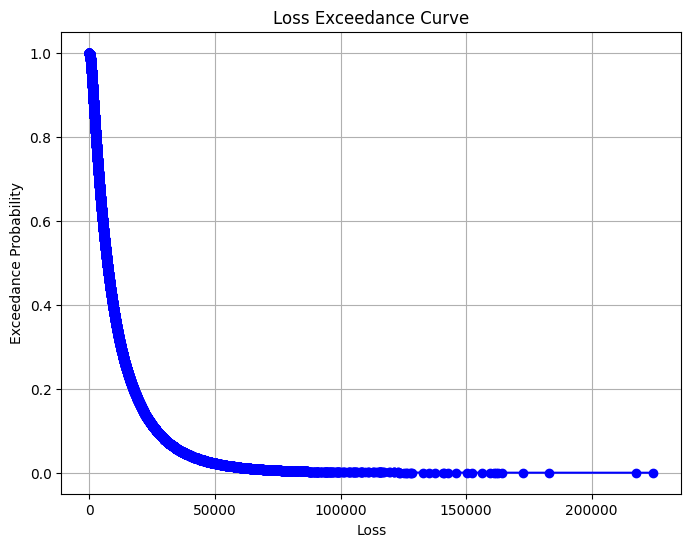

In [28]:
import matplotlib.pyplot as plt

x = np.array(risk.result())
# Sort the data
sorted_losses = np.sort(x)

# Calculate exceedance probabilities
n = len(sorted_losses)
exceedance_probs = (n - np.arange(n)) / n

# Plot the loss exceedance curve
plt.figure(figsize=(8, 6))
plt.plot(sorted_losses, exceedance_probs, marker='o', linestyle='-', color='b')
plt.xlabel('Loss')
plt.ylabel('Exceedance Probability')
plt.title('Loss Exceedance Curve')
plt.grid(True)
plt.show()